In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from matplotlib.pyplot import subplots, show

# Large System Ising Model
We run the simulation shown in *Rank-adaptive time integration of tree tensor networks* (Ceruti, et. al. 2022). Which is the Ising model
$$
 H = -J \sum_{k=1}^{L-1} Z_k Z_{k+1}- g \sum_{k=1}^L X_k,
$$
for $J=g=1$ and $L=10$ sites.

In [32]:
local_dim = 2
num_sites = 10
time_step_size = 0.01
final_time = 5
coupling = 1
field = 1

## Exact Solution

In [33]:
from pytreenet.operators.exact_operators import (flipped_exact_ising_hamiltonian,
                                                 exact_local_magnetisation,
                                                 exact_zero_state)
from pytreenet.time_evolution.exact_time_evolution import ExactTimeEvolution

In [34]:
exact_hamiltonian = flipped_exact_ising_hamiltonian(coupling, field, num_sites)
site_ids = [f"Qubit_{i}" for i in range(num_sites)]
exact_operators = exact_local_magnetisation(site_ids)
exact_intital_state = exact_zero_state(num_sites, local_dim)

print("Hamiltonian Shape:", exact_hamiltonian.shape)
print("Operators Shape:", exact_operators[site_ids[0]].shape)
print("Initial State Shape:", exact_intital_state.shape)

Hamiltonian Shape: (1024, 1024)
Operators Shape: (1024, 1024)
Initial State Shape: (1024,)


In [35]:
exact_evo = ExactTimeEvolution(exact_intital_state,
                               exact_hamiltonian,
                               time_step_size, final_time,
                               exact_operators)

In [36]:
exact_evo.run()

100%|██████████| 501/501 [00:02<00:00, 197.54it/s]


## Binary TTN

In [37]:
from copy import deepcopy

from numpy import zeros, eye, max as npmax

from pytreenet.ttns import TreeTensorNetworkState
from pytreenet.special_ttn.binary import generate_binary_ttns
from pytreenet.core.node import Node
from pytreenet.operators.models import flipped_ising_model, local_magnetisation
from pytreenet.operators.common_operators import ket_i
from pytreenet.ttno import TreeTensorNetworkOperator
from pytreenet.operators.tensorproduct import TensorProduct
from pytreenet.time_evolution.bug import BUG, BUGConfig

In [38]:
pad_dim = 2
qubit_tensor = zeros((pad_dim,local_dim), dtype=complex)
qubit_tensor[0,:] = ket_i(0,local_dim)

binary_ttns = generate_binary_ttns(num_sites, pad_dim, qubit_tensor,
                                    "Qubit_","Virtual_")

for node in binary_ttns.nodes.values():
    print(node.identifier, node.shape, node.children)

Virtual_0_0 (2, 2, 1) ['Virtual_1_0', 'Virtual_1_1']
Virtual_1_0 (2, 2, 2, 1) ['Virtual_2_0', 'Virtual_2_1']
Virtual_1_1 (2, 2, 2, 1) ['Virtual_2_2', 'Virtual_2_3']
Virtual_2_0 (2, 2, 2, 1) ['Virtual_3_0', 'Virtual_3_1']
Virtual_2_1 (2, 2, 2, 1) ['Qubit_0', 'Qubit_1']
Virtual_2_2 (2, 2, 2, 1) ['Qubit_2', 'Qubit_3']
Virtual_2_3 (2, 2, 2, 1) ['Qubit_4', 'Qubit_5']
Virtual_3_0 (2, 2, 2, 1) ['Qubit_6', 'Qubit_7']
Virtual_3_1 (2, 2, 2, 1) ['Qubit_8', 'Qubit_9']
Qubit_0 (2, 2) []
Qubit_1 (2, 2) []
Qubit_2 (2, 2) []
Qubit_3 (2, 2) []
Qubit_4 (2, 2) []
Qubit_5 (2, 2) []
Qubit_6 (2, 2) []
Qubit_7 (2, 2) []
Qubit_8 (2, 2) []
Qubit_9 (2, 2) []


In [39]:
nearest_neighbours = [site_ids[i:i+2] for i in range(num_sites-1)]
print("Nearest Neighbours:", nearest_neighbours)
ising_ham = flipped_ising_model(nearest_neighbours, field, factor=coupling)
print("Ising Hamiltonian:", ising_ham)
binary_ttno = TreeTensorNetworkOperator.from_hamiltonian(ising_ham, binary_ttns)

Nearest Neighbours: [['Qubit_0', 'Qubit_1'], ['Qubit_1', 'Qubit_2'], ['Qubit_2', 'Qubit_3'], ['Qubit_3', 'Qubit_4'], ['Qubit_4', 'Qubit_5'], ['Qubit_5', 'Qubit_6'], ['Qubit_6', 'Qubit_7'], ['Qubit_7', 'Qubit_8'], ['Qubit_8', 'Qubit_9']]
Ising Hamiltonian: [(Fraction(-1, 1), 'ext_magn', {'Qubit_5': 'X'}), (Fraction(-1, 1), 'ext_magn', {'Qubit_3': 'X'}), (Fraction(-1, 1), 'ext_magn', {'Qubit_9': 'X'}), (Fraction(-1, 1), 'ext_magn', {'Qubit_6': 'X'}), (Fraction(-1, 1), 'ext_magn', {'Qubit_2': 'X'}), (Fraction(-1, 1), 'ext_magn', {'Qubit_1': 'X'}), (Fraction(-1, 1), 'ext_magn', {'Qubit_8': 'X'}), (Fraction(-1, 1), 'ext_magn', {'Qubit_4': 'X'}), (Fraction(-1, 1), 'ext_magn', {'Qubit_7': 'X'}), (Fraction(-1, 1), 'ext_magn', {'Qubit_0': 'X'}), (Fraction(-1, 1), 'coupling', {'Qubit_0': 'Z', 'Qubit_1': 'Z'}), (Fraction(-1, 1), 'coupling', {'Qubit_1': 'Z', 'Qubit_2': 'Z'}), (Fraction(-1, 1), 'coupling', {'Qubit_2': 'Z', 'Qubit_3': 'Z'}), (Fraction(-1, 1), 'coupling', {'Qubit_3': 'Z', 'Qubit_4': 

In [40]:
operators = local_magnetisation(site_ids, with_factor=False)
operators["energy"] = binary_ttno
operators["norm"] = TensorProduct({site_ids[0]: eye(local_dim)})
print(operators)

{'Qubit_0': {'Qubit_0': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_1': {'Qubit_1': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_2': {'Qubit_2': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_3': {'Qubit_3': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_4': {'Qubit_4': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_5': {'Qubit_5': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_6': {'Qubit_6': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_7': {'Qubit_7': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_8': {'Qubit_8': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'Qubit_9': {'Qubit_9': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}, 'energy': <pytreenet.ttno.ttno_class.TreeTensorNetworkOperator object at 0x0000019B6F261C10>, 'norm': {'Qubit_0': array([[1., 0.],
       [0., 1.]])}}


In [41]:
max_bond_dim = 2**7
total_tols = [1e-4,1e-6,1e-8,1e-10,0]
binary_bugs = []
for total_tol in total_tols:
    bug_config = BUGConfig(max_bond_dim=max_bond_dim,
                               total_tol=total_tol,
                               sum_trunc=True,
                               sum_renorm=False)
    binary_bug = BUG(deepcopy(binary_ttns), binary_ttno,
                    time_step_size, final_time,
                    operators,
                    config=bug_config)
    binary_bugs.append(binary_bug)

In [42]:
for bug in binary_bugs:
    bug.run()

100%|██████████| 501/501 [01:14<00:00,  6.77it/s]


In [43]:
for bug in binary_bugs:
    print(bug.state.bond_dims())

{('Virtual_0_0', 'Virtual_1_0'): 16, ('Virtual_0_0', 'Virtual_1_1'): 16, ('Virtual_1_0', 'Virtual_2_0'): 16, ('Virtual_1_0', 'Virtual_2_1'): 4, ('Virtual_1_1', 'Virtual_2_2'): 4, ('Virtual_1_1', 'Virtual_2_3'): 4, ('Virtual_2_0', 'Virtual_3_0'): 4, ('Virtual_2_0', 'Virtual_3_1'): 4, ('Virtual_2_1', 'Qubit_0'): 2, ('Virtual_2_1', 'Qubit_1'): 2, ('Virtual_2_2', 'Qubit_2'): 2, ('Virtual_2_2', 'Qubit_3'): 2, ('Virtual_2_3', 'Qubit_4'): 2, ('Virtual_2_3', 'Qubit_5'): 2, ('Virtual_3_0', 'Qubit_6'): 2, ('Virtual_3_0', 'Qubit_7'): 2, ('Virtual_3_1', 'Qubit_8'): 2, ('Virtual_3_1', 'Qubit_9'): 2}
{('Virtual_0_0', 'Virtual_1_0'): 16, ('Virtual_0_0', 'Virtual_1_1'): 16, ('Virtual_1_0', 'Virtual_2_0'): 16, ('Virtual_1_0', 'Virtual_2_1'): 4, ('Virtual_1_1', 'Virtual_2_2'): 4, ('Virtual_1_1', 'Virtual_2_3'): 4, ('Virtual_2_0', 'Virtual_3_0'): 4, ('Virtual_2_0', 'Virtual_3_1'): 4, ('Virtual_2_1', 'Qubit_0'): 2, ('Virtual_2_1', 'Qubit_1'): 2, ('Virtual_2_2', 'Qubit_2'): 2, ('Virtual_2_2', 'Qubit_3'): 2

### Binary Tree: Plotting Results

In [44]:
from numpy import abs as npabs
from pytreenet.operators.models import total_magnetisation

In [45]:
times = binary_bugs[0].times()
for bug in binary_bugs:
    print("The results are approximately real:", bug.results_real())

The results are approximately real: True
The results are approximately real: True
The results are approximately real: True
The results are approximately real: True
The results are approximately real: True


In [46]:
norms = [bug.operator_result("norm", realise=True) for bug in binary_bugs]
norm_errors = [npabs(norm - 1) for norm in norms]

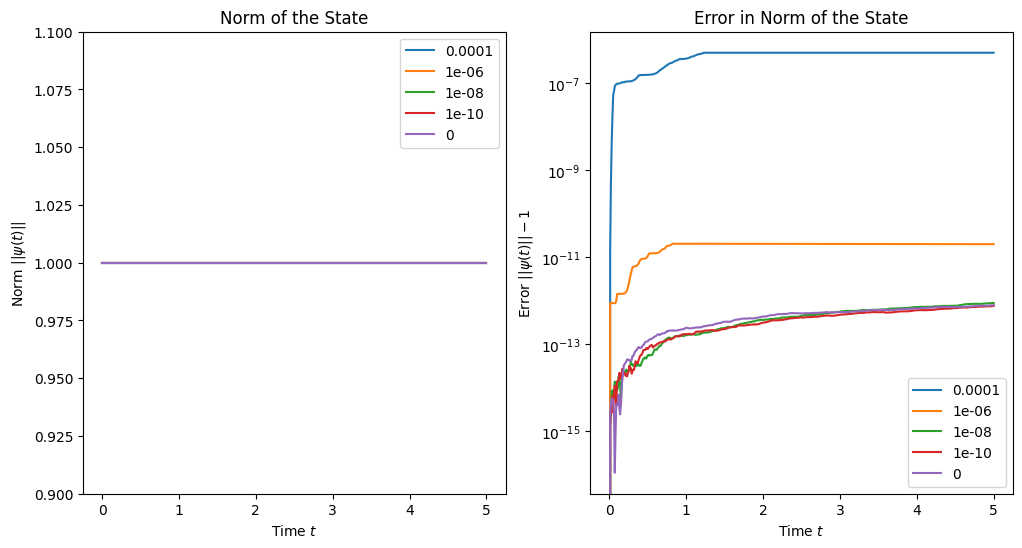

In [47]:
fig, ax = subplots(1, 2 , figsize=(12,6))
for i, bug in enumerate(binary_bugs):
    ax[0].plot(times, norms[i], label=f"{total_tols[i]}")
ax[0].set_ylim(0.9,1.1)
ax[0].set_title("Norm of the State")
ax[0].set_xlabel("Time $t$")
ax[0].set_ylabel("Norm $||\psi(t)||$")
ax[0].legend()

for i, bug in enumerate(binary_bugs):
    ax[1].semilogy(times, norm_errors[i], label=f"{total_tols[i]}")
ax[1].set_title("Error in Norm of the State")
ax[1].set_xlabel("Time $t$")
ax[1].set_ylabel("Error $||\psi(t)|| - 1$")
ax[1].legend()

show()

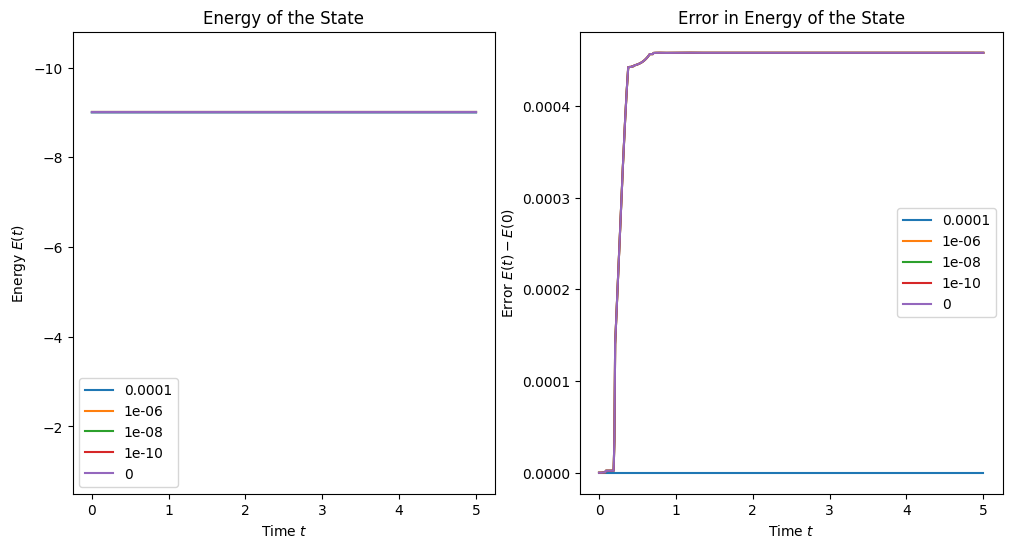

In [48]:
energies = [bug.operator_result("energy", realise=True) for bug in binary_bugs]
energy_errors = [npabs(energy - energies[0]) for energy in energies]

fig, ax = subplots(1, 2 , figsize=(12,6))
for i, bug in enumerate(binary_bugs):
    ax[0].plot(times, energies[i], label=f"{total_tols[i]}")
ax[0].set_ylim(-0.5, npmax(energies)*1.2)
ax[0].set_title("Energy of the State")
ax[0].set_xlabel("Time $t$")
ax[0].set_ylabel("Energy $E(t)$")
ax[0].legend()

for i, bug in enumerate(binary_bugs):
    ax[1].plot(times, energy_errors[i], label=f"{total_tols[i]}")
ax[1].set_title("Error in Energy of the State")
ax[1].set_xlabel("Time $t$")
ax[1].set_ylabel("Error $E(t) - E(0)$")
ax[1].legend()

show()

In [49]:
exact_local_magnetisation_results = [exact_evo.operator_result(identifier, realise=True) for identifier in site_ids]
exact_total_magnetisation_result = total_magnetisation(exact_local_magnetisation_results)
bug_total_magnetisation_results = []
bug_total_magn_erros = []
for bug in binary_bugs:
    bug_local_magnetisation_results = [bug.operator_result(identifier, realise=True) for identifier in site_ids]
    bug_total_magnetisation_results.append(total_magnetisation(bug_local_magnetisation_results))
    bug_total_magn_erros.append(npabs(bug_total_magnetisation_results[-1] - exact_total_magnetisation_result))

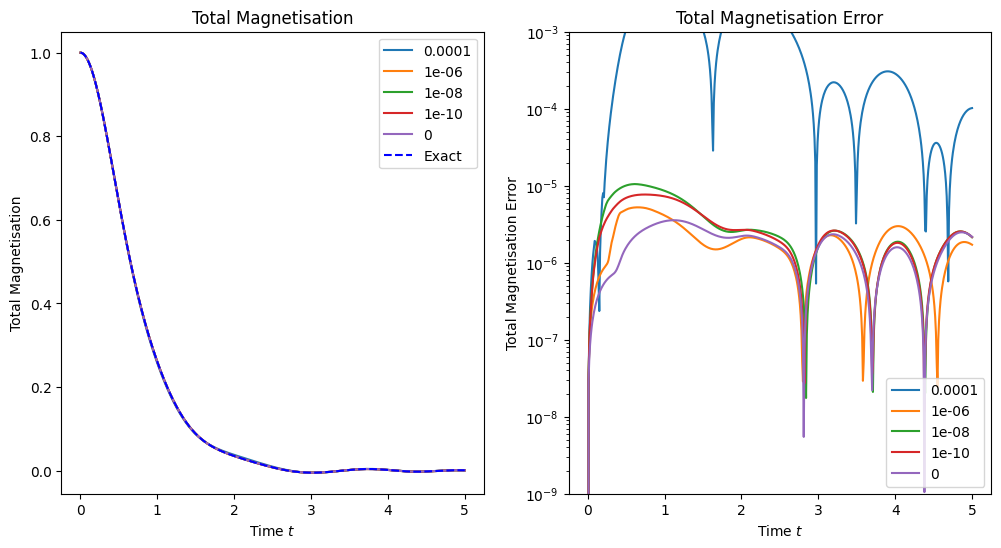

In [50]:
fig, ax = subplots(1, 2, figsize=(12, 6))
for i, bug in enumerate(binary_bugs):
    ax[0].plot(times, bug_total_magnetisation_results[i], label=f"{total_tols[i]}")
ax[0].plot(times, exact_total_magnetisation_result, label="Exact", color="b", linestyle="--")
ax[0].set_xlabel("Time $t$")
ax[0].set_ylabel("Total Magnetisation")
ax[0].legend()
ax[0].set_title("Total Magnetisation")

for i, bug in enumerate(binary_bugs):
    ax[1].semilogy(times, bug_total_magn_erros[i], label=f"{total_tols[i]}")
ax[1].set_ylim(1e-9, 1e-3)
ax[1].set_xlabel("Time $t$")
ax[1].set_ylabel("Total Magnetisation Error")
ax[1].set_title("Total Magnetisation Error")
ax[1].legend()

show()

In [51]:
for bug in binary_bugs:
    print(bug.state.bond_dims())

{('Virtual_0_0', 'Virtual_1_0'): 16, ('Virtual_0_0', 'Virtual_1_1'): 16, ('Virtual_1_0', 'Virtual_2_0'): 16, ('Virtual_1_0', 'Virtual_2_1'): 4, ('Virtual_1_1', 'Virtual_2_2'): 4, ('Virtual_1_1', 'Virtual_2_3'): 4, ('Virtual_2_0', 'Virtual_3_0'): 4, ('Virtual_2_0', 'Virtual_3_1'): 4, ('Virtual_2_1', 'Qubit_0'): 2, ('Virtual_2_1', 'Qubit_1'): 2, ('Virtual_2_2', 'Qubit_2'): 2, ('Virtual_2_2', 'Qubit_3'): 2, ('Virtual_2_3', 'Qubit_4'): 2, ('Virtual_2_3', 'Qubit_5'): 2, ('Virtual_3_0', 'Qubit_6'): 2, ('Virtual_3_0', 'Qubit_7'): 2, ('Virtual_3_1', 'Qubit_8'): 2, ('Virtual_3_1', 'Qubit_9'): 2}
{('Virtual_0_0', 'Virtual_1_0'): 16, ('Virtual_0_0', 'Virtual_1_1'): 16, ('Virtual_1_0', 'Virtual_2_0'): 16, ('Virtual_1_0', 'Virtual_2_1'): 4, ('Virtual_1_1', 'Virtual_2_2'): 4, ('Virtual_1_1', 'Virtual_2_3'): 4, ('Virtual_2_0', 'Virtual_3_0'): 4, ('Virtual_2_0', 'Virtual_3_1'): 4, ('Virtual_2_1', 'Qubit_0'): 2, ('Virtual_2_1', 'Qubit_1'): 2, ('Virtual_2_2', 'Qubit_2'): 2, ('Virtual_2_2', 'Qubit_3'): 2

## Test on an MPS

In [78]:
from pytreenet.special_ttn.mps import MatrixProductState

In [79]:
mps = MatrixProductState.constant_product_state(0,2,num_sites,
                                                node_prefix="Qubit_",
                                                root_site=5,
                                                bond_dimensions=[2]*(num_sites-1))
for node in mps.nodes.values():
    print(node.identifier, node.shape, node.children)

Qubit_5 (2, 2, 2) ['Qubit_4', 'Qubit_6']
Qubit_4 (2, 2, 2) ['Qubit_3']
Qubit_3 (2, 2, 2) ['Qubit_2']
Qubit_2 (2, 2, 2) ['Qubit_1']
Qubit_1 (2, 2, 2) ['Qubit_0']
Qubit_0 (2, 2) []
Qubit_6 (2, 2, 2) ['Qubit_7']
Qubit_7 (2, 2, 2) ['Qubit_8']
Qubit_8 (2, 2, 2) ['Qubit_9']
Qubit_9 (2, 2) []


In [80]:
nearest_neighbours = [site_ids[i:i+2] for i in range(num_sites-1)]
ising_ham = flipped_ising_model(nearest_neighbours, field, factor=coupling)
mps_ttno = TreeTensorNetworkOperator.from_hamiltonian(ising_ham, mps)

In [81]:
operators = local_magnetisation(site_ids, with_factor=False)
operators["energy"] = mps_ttno
operators["norm"] = TensorProduct({site_ids[0]: eye(local_dim)})

In [82]:
max_bond_dim = 2**(int(num_sites/2))
total_tols = [1e-4,1e-6,1e-8,1e-10,0]
mps_bugs = []
for total_tol in total_tols:
    bug_config = BUGConfig(max_bond_dim=max_bond_dim,
                               total_tol=total_tol,
                               sum_trunc=True,
                               sum_renorm=False)
    mps_bug = BUG(deepcopy(mps), mps_ttno,
                    time_step_size, final_time,
                    operators,
                    config=bug_config)
    mps_bugs.append(mps_bug)

In [83]:
for bug in mps_bugs:
    bug.run()

100%|██████████| 501/501 [01:49<00:00,  4.58it/s]


#### Plotting MPS

In [84]:
from numpy import abs as npabs
from pytreenet.operators.models import total_magnetisation

In [85]:
times = mps_bugs[0].times()
for bug in mps_bugs:
    print("The results are approximately real:", bug.results_real())

The results are approximately real: True
The results are approximately real: True
The results are approximately real: True
The results are approximately real: True
The results are approximately real: True


In [90]:
norms = [bug.operator_result("norm", realise=True) for bug in mps_bugs]
norm_errors = [npabs(norm - 1) for norm in norms]

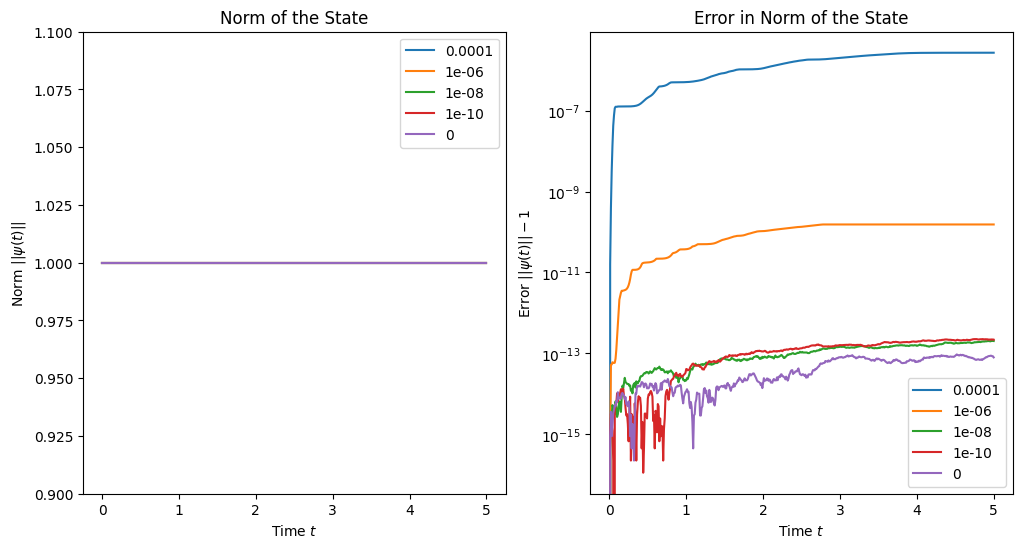

In [91]:
fig, ax = subplots(1, 2 , figsize=(12,6))
for i, bug in enumerate(mps_bugs):
    ax[0].plot(times, norms[i], label=f"{total_tols[i]}")
ax[0].set_ylim(0.9,1.1)
ax[0].set_title("Norm of the State")
ax[0].set_xlabel("Time $t$")
ax[0].set_ylabel("Norm $||\psi(t)||$")
ax[0].legend()

for i, bug in enumerate(mps_bugs):
    ax[1].semilogy(times, norm_errors[i], label=f"{total_tols[i]}")
ax[1].set_title("Error in Norm of the State")
ax[1].set_xlabel("Time $t$")
ax[1].set_ylabel("Error $||\psi(t)|| - 1$")
ax[1].legend()

show()

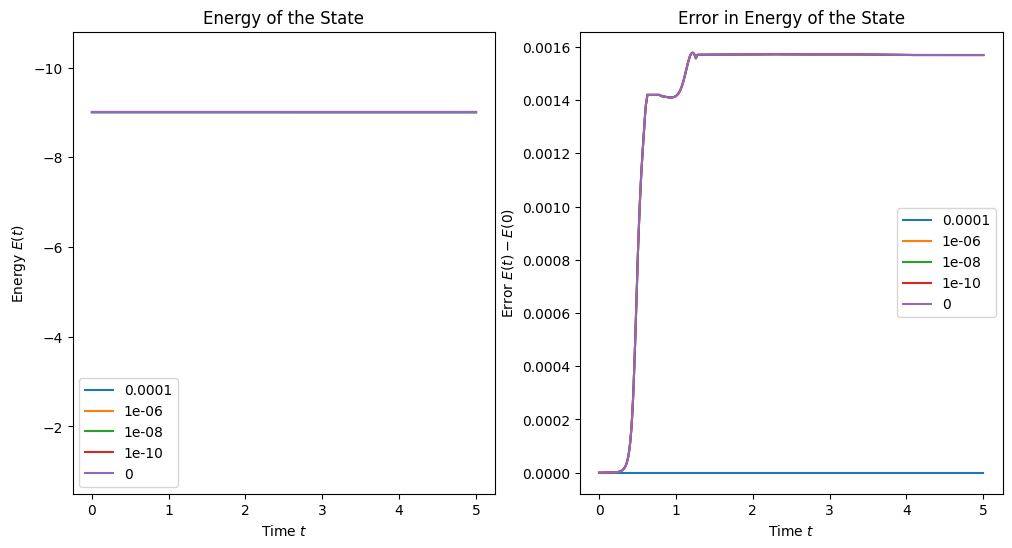

In [92]:
energies = [bug.operator_result("energy", realise=True) for bug in mps_bugs]
energy_errors = [npabs(energy - energies[0]) for energy in energies]

fig, ax = subplots(1, 2 , figsize=(12,6))
for i, bug in enumerate(mps_bugs):
    ax[0].plot(times, energies[i], label=f"{total_tols[i]}")
ax[0].set_ylim(-0.5, npmax(energies)*1.2)
ax[0].set_title("Energy of the State")
ax[0].set_xlabel("Time $t$")
ax[0].set_ylabel("Energy $E(t)$")
ax[0].legend()

for i, bug in enumerate(mps_bugs):
    ax[1].plot(times, energy_errors[i], label=f"{total_tols[i]}")
ax[1].set_title("Error in Energy of the State")
ax[1].set_xlabel("Time $t$")
ax[1].set_ylabel("Error $E(t) - E(0)$")
ax[1].legend()

show()

In [93]:
exact_local_magnetisation_results = [exact_evo.operator_result(identifier, realise=True) for identifier in site_ids]
exact_total_magnetisation_result = total_magnetisation(exact_local_magnetisation_results)
bug_total_magnetisation_results = []
bug_total_magn_erros = []
for bug in mps_bugs:
    bug_local_magnetisation_results = [bug.operator_result(identifier, realise=True) for identifier in site_ids]
    bug_total_magnetisation_results.append(total_magnetisation(bug_local_magnetisation_results))
    bug_total_magn_erros.append(npabs(bug_total_magnetisation_results[-1] - exact_total_magnetisation_result))

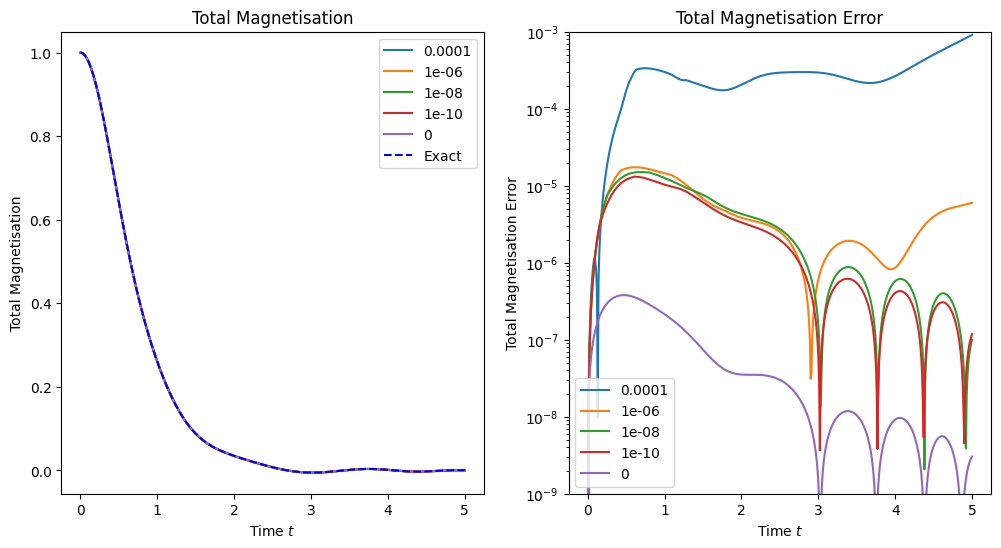

In [94]:
fig, ax = subplots(1, 2, figsize=(12, 6))
for i, bug in enumerate(mps_bugs):
    ax[0].plot(times, bug_total_magnetisation_results[i], label=f"{total_tols[i]}")
ax[0].plot(times, exact_total_magnetisation_result, label="Exact", color="b", linestyle="--")
ax[0].set_xlabel("Time $t$")
ax[0].set_ylabel("Total Magnetisation")
ax[0].legend()
ax[0].set_title("Total Magnetisation")

for i, bug in enumerate(mps_bugs):
    ax[1].semilogy(times, bug_total_magn_erros[i], label=f"{total_tols[i]}")
ax[1].set_ylim(1e-9, 1e-3)
ax[1].set_xlabel("Time $t$")
ax[1].set_ylabel("Total Magnetisation Error")
ax[1].set_title("Total Magnetisation Error")
ax[1].legend()

show()